# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 32D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 32  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), cvx_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L1 loss -- Train

In [ ]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 24.63384246826172
iteration 0 loss 11.764966011047363
iteration 500 loss 2.4762516021728516
iteration 1000 loss 2.3929858207702637


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=16) ---
loss -3.7354559898376465


loss -66.82245635986328


loss -106.66447448730469


loss -139.44873046875


loss -166.18563842773438


loss -188.1255340576172


loss -206.21493530273438


loss -221.03616333007812


loss -233.01632690429688


loss -242.53126525878906


loss -249.94911193847656


loss -255.60289001464844


loss -259.7560729980469


loss -262.6452331542969


loss -264.514892578125


loss -265.6133728027344


loss -266.181640625


loss -266.4312744140625


loss -266.52020263671875


loss -266.5444030761719


loss -266.5491027832031


loss -266.5496520996094


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5496826171875


loss -266.5496826171875


loss -266.5497131347656


loss -266.5497131347656


final mse:  1.2144573124928115e-09
max, min: 6.8333225 -6.5729055
loss -3.7354559898376465


loss -69.378662109375


loss -109.80612182617188


loss -143.7202606201172


loss -172.30618286132812


loss -196.1181640625


loss -215.4666748046875


loss -230.64776611328125


loss -242.24752807617188


loss -251.015869140625


loss -257.6614990234375


loss -262.68524169921875


loss -266.4266662597656


loss -269.13079833984375


loss -270.98406982421875


loss -272.1536865234375


loss -272.8128662109375


loss -273.13372802734375


loss -273.2635803222656


loss -273.3051452636719


loss -273.3150634765625


loss -273.3166809082031


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.31683349609375


loss -273.31683349609375


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.31683349609375


loss -273.31683349609375


loss -273.3168640136719


final mse:  8.961067998747296e-10
max, min: 6.607749 -6.9895196


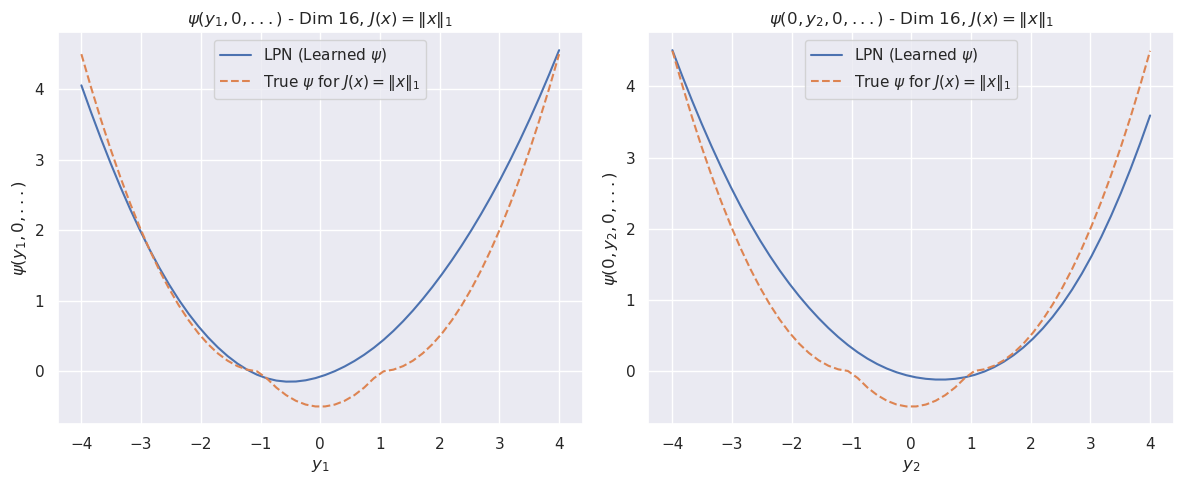

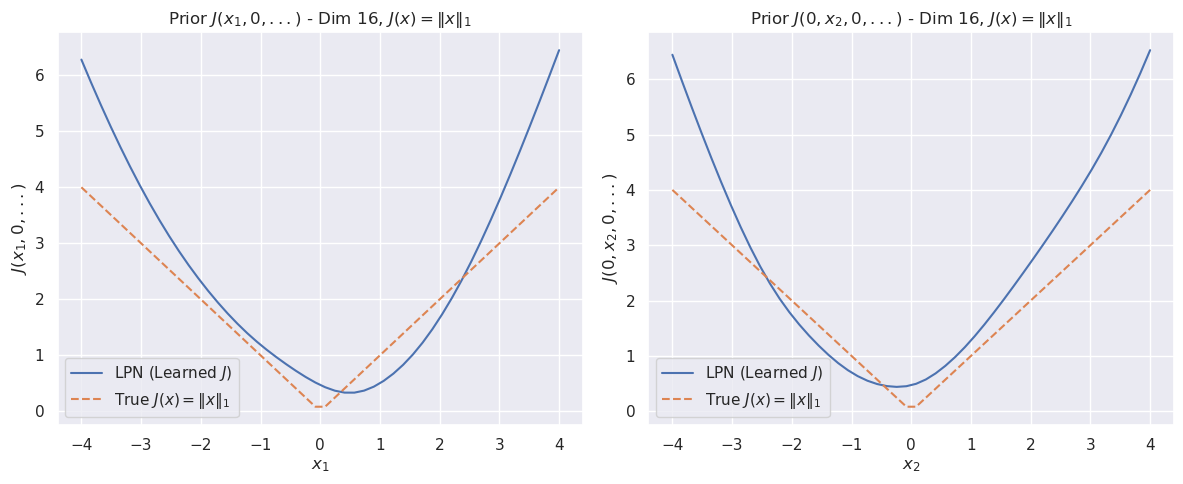

In [12]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)

In [13]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

y_k_tensor = lpn_model_quad_l1(x_k_tensor)

inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

Generated G samples: G_samples_tensor shape torch.Size([30000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 673.2371215820312
iteration 0 loss 352.5652770996094


iteration 500 loss 10.200592041015625


iteration 1000 loss 8.788565635681152


iteration 1500 loss 8.012038230895996


iteration 2000 loss 7.396777153015137


iteration 2500 loss 6.7193779945373535


iteration 3000 loss 5.9071760177612305


iteration 3500 loss 4.919990062713623


iteration 4000 loss 3.711352586746216


iteration 4500 loss 2.3293209075927734


iteration 5000 loss 1.3262107372283936


iteration 5500 loss 0.9876176118850708


iteration 6000 loss 0.8107592463493347


iteration 6500 loss 0.6851034164428711


iteration 7000 loss 0.5915391445159912


iteration 7500 loss 0.5194832682609558


iteration 8000 loss 0.45845022797584534


iteration 8500 loss 0.40587612986564636


iteration 9000 loss 0.36099159717559814


iteration 9500 loss 0.3246828019618988


iteration 10000 loss 0.2943057715892792


iteration 10500 loss 0.26900649070739746


iteration 11000 loss 0.2504095435142517


iteration 11500 loss 0.23562505841255188


iteration 12000 loss 0.22470322251319885


iteration 12500 loss 0.21447256207466125


iteration 13000 loss 0.2063656896352768


iteration 13500 loss 0.19836999475955963


iteration 14000 loss 0.1918601244688034


iteration 14500 loss 0.18605665862560272


iteration 15000 loss 0.1811770498752594


iteration 15500 loss 0.1769265979528427


iteration 16000 loss 0.17344316840171814


iteration 16500 loss 0.17010001838207245


iteration 17000 loss 0.16760165989398956


iteration 17500 loss 0.16469447314739227


iteration 18000 loss 0.16237777471542358


iteration 18500 loss 0.16002321243286133


iteration 19000 loss 0.15804536640644073


iteration 19500 loss 0.15602393448352814


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.15442727506160736


iteration 20500 loss 0.1542198210954666


iteration 21000 loss 0.1539657562971115


iteration 21500 loss 0.153643399477005


iteration 22000 loss 0.15323613584041595


iteration 22500 loss 0.1527244746685028


iteration 23000 loss 0.15208746492862701


iteration 23500 loss 0.151302769780159


iteration 24000 loss 0.15034978091716766


iteration 24500 loss 0.14921490848064423


iteration 25000 loss 0.14791272580623627


iteration 25500 loss 0.14652936160564423


iteration 26000 loss 0.14521433413028717


iteration 26500 loss 0.14397555589675903


iteration 27000 loss 0.1428045630455017


iteration 27500 loss 0.1416996568441391


iteration 28000 loss 0.1406445950269699


iteration 28500 loss 0.1396375298500061


iteration 29000 loss 0.13868586719036102


iteration 29500 loss 0.13778401911258698


iteration 30000 loss 0.13692937791347504


iteration 30500 loss 0.1361209750175476


iteration 31000 loss 0.13535605370998383


iteration 31500 loss 0.13463038206100464


iteration 32000 loss 0.1339375078678131


iteration 32500 loss 0.13327808678150177


iteration 33000 loss 0.13265566527843475


iteration 33500 loss 0.13206037878990173


iteration 34000 loss 0.13149960339069366


iteration 34500 loss 0.1309579759836197


iteration 35000 loss 0.13044263422489166


iteration 35500 loss 0.1299562007188797


iteration 36000 loss 0.1294998675584793


iteration 36500 loss 0.129050150513649


iteration 37000 loss 0.12861886620521545


iteration 37500 loss 0.12820228934288025


iteration 38000 loss 0.12780506908893585


iteration 38500 loss 0.12742389738559723


iteration 39000 loss 0.12705537676811218


iteration 39500 loss 0.1267014443874359


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.12635928392410278


iteration 40500 loss 0.12632343173027039


iteration 41000 loss 0.12627926468849182


iteration 41500 loss 0.12622545659542084


iteration 42000 loss 0.12616121768951416


iteration 42500 loss 0.12608595192432404


iteration 43000 loss 0.12599964439868927


iteration 43500 loss 0.12590308487415314


iteration 44000 loss 0.12579746544361115


iteration 44500 loss 0.12568436563014984


iteration 45000 loss 0.12556560337543488


iteration 45500 loss 0.1254437118768692


iteration 46000 loss 0.1253211796283722


iteration 46500 loss 0.12520091235637665


iteration 47000 loss 0.12508255243301392


iteration 47500 loss 0.12496598809957504


iteration 48000 loss 0.12485110759735107


iteration 48500 loss 0.1247376948595047


iteration 49000 loss 0.12462572008371353


iteration 49500 loss 0.1245151236653328


iteration 50000 loss 0.12440597265958786


iteration 50500 loss 0.12429793179035187


iteration 51000 loss 0.12419094145298004


iteration 51500 loss 0.12408502399921417


iteration 52000 loss 0.12398006021976471


iteration 52500 loss 0.12387628108263016


iteration 53000 loss 0.12377341091632843


iteration 53500 loss 0.12367137521505356


iteration 54000 loss 0.12357056885957718


iteration 54500 loss 0.12347039580345154


iteration 55000 loss 0.12337101250886917


iteration 55500 loss 0.12327251583337784


iteration 56000 loss 0.12317490577697754


iteration 56500 loss 0.12307778000831604


iteration 57000 loss 0.12298154085874557


iteration 57500 loss 0.12288583070039749


iteration 58000 loss 0.1227910965681076


iteration 58500 loss 0.1226968914270401


iteration 59000 loss 0.12260356545448303


iteration 59500 loss 0.12251074612140656


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.12241842597723007


iteration 60500 loss 0.12240903824567795


iteration 61000 loss 0.12239920347929001


iteration 61500 loss 0.12238911539316177


iteration 62000 loss 0.12237879633903503


iteration 62500 loss 0.12236824631690979


iteration 63000 loss 0.12235762178897858


iteration 63500 loss 0.122346892952919


iteration 64000 loss 0.12233611941337585


iteration 64500 loss 0.12232531607151031


iteration 65000 loss 0.12231452018022537


iteration 65500 loss 0.12230371683835983


iteration 66000 loss 0.12229293584823608


iteration 66500 loss 0.12228217720985413


iteration 67000 loss 0.12227143347263336


iteration 67500 loss 0.12226072698831558


iteration 68000 loss 0.122250035405159


iteration 68500 loss 0.12223934382200241


iteration 69000 loss 0.12222868204116821


iteration 69500 loss 0.1222180426120758


iteration 70000 loss 0.12220742553472519


iteration 70500 loss 0.12219683080911636


iteration 71000 loss 0.12218625098466873


iteration 71500 loss 0.1221756711602211


iteration 72000 loss 0.12216511368751526


iteration 72500 loss 0.1221545934677124


iteration 73000 loss 0.12214405834674835


iteration 73500 loss 0.12213356792926788


iteration 74000 loss 0.12212307006120682


iteration 74500 loss 0.12211260944604874


iteration 75000 loss 0.12210215628147125


iteration 75500 loss 0.12209171801805496


iteration 76000 loss 0.12208127230405807


iteration 76500 loss 0.12207083404064178


iteration 77000 loss 0.12206040322780609


iteration 77500 loss 0.122049979865551


iteration 78000 loss 0.12203961610794067


iteration 78500 loss 0.12202922999858856


iteration 79000 loss 0.12201886624097824


iteration 79500 loss 0.12200850248336792


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.12199817597866058


iteration 80500 loss 0.12199714779853821


iteration 81000 loss 0.12199611216783524


iteration 81500 loss 0.12199506908655167


iteration 82000 loss 0.12199404090642929


iteration 82500 loss 0.12199299782514572


iteration 83000 loss 0.12199195474386215


iteration 83500 loss 0.12199091911315918


iteration 84000 loss 0.12198985368013382


iteration 84500 loss 0.12198885530233383


iteration 85000 loss 0.12198780477046967


iteration 85500 loss 0.1219867616891861


iteration 86000 loss 0.12198573350906372


iteration 86500 loss 0.12198468297719955


iteration 87000 loss 0.12198365479707718


iteration 87500 loss 0.1219826191663742


iteration 88000 loss 0.12198159098625183


iteration 88500 loss 0.12198054790496826


iteration 89000 loss 0.12197951227426529


iteration 89500 loss 0.12197849154472351


iteration 90000 loss 0.12197745591402054


iteration 90500 loss 0.12197642028331757


iteration 91000 loss 0.12197539210319519


iteration 91500 loss 0.12197434902191162


iteration 92000 loss 0.12197332829236984


iteration 92500 loss 0.12197229266166687


iteration 93000 loss 0.1219712495803833


iteration 93500 loss 0.12197024375200272


iteration 94000 loss 0.12196920812129974


iteration 94500 loss 0.12196817994117737


iteration 95000 loss 0.12196716666221619


iteration 95500 loss 0.12196611613035202


iteration 96000 loss 0.12196507304906845


iteration 96500 loss 0.12196404486894608


iteration 97000 loss 0.12196303904056549


iteration 97500 loss 0.12196199595928192


iteration 98000 loss 0.12196099013090134


iteration 98500 loss 0.12195993959903717


iteration 99000 loss 0.1219589114189148


iteration 99500 loss 0.12195789813995361


Training of LPN for G(x) complete and model saved.


In [ ]:
# --- Step 3: Train 2nd LPN ---
print("\n--- Training Second LPN for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=1, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Plotting Estimated Prior J(x) from LPN 2 ---


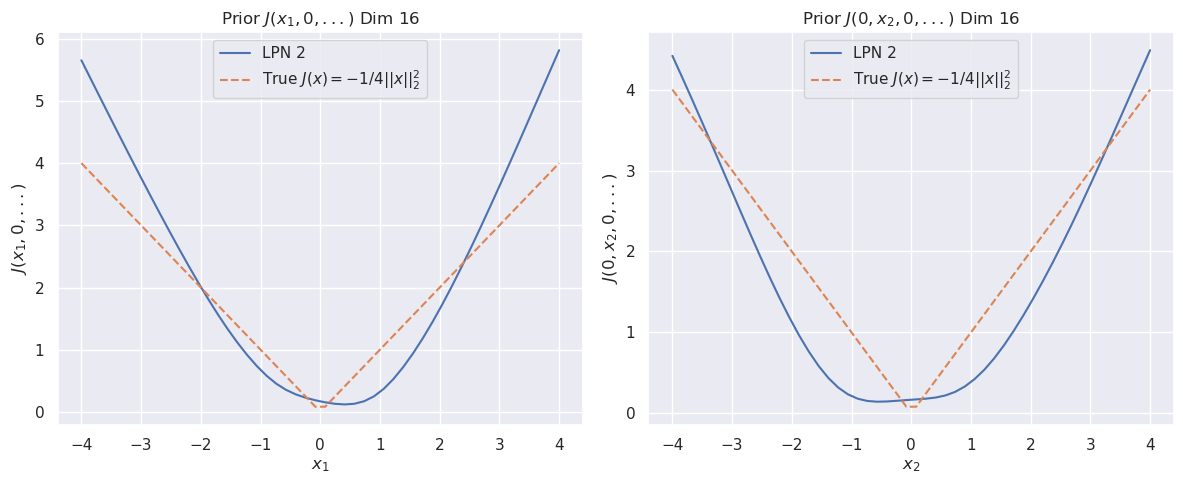

In [14]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)